TASC6/KASC13 Workshop
--

---

# Stellar Models for Asteroseismology


by [Earl Patrick Bellinger](https://earlbellinger.com)$^{1,2}$

$^1$_Max Planck Institute for Astrophysics, Garching, Germany_ \
$^2$_Stellar Astrophysics Centre, Aarhus, Denmark_

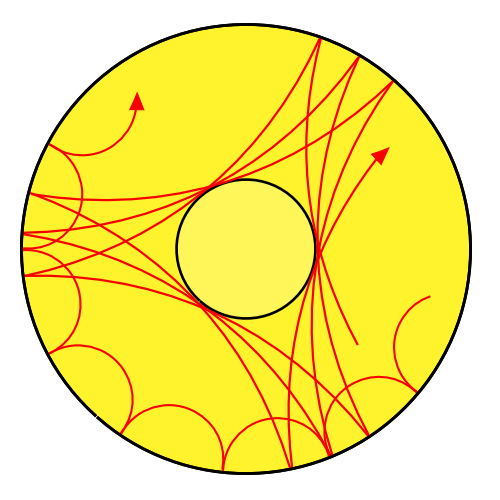

## Installation

This tutorial is about [MESA](https://docs.mesastar.org/) and [GYRE](https://gyre.readthedocs.io). Let's install them!

In the `src/` directory you will find `install_mesa.sh`. Run it line-by-line so that you may catch any errors that crop up. You will likely need to install some extra packages along the way, and then start over from the beginning. 


Once the installation script is finished, you should see: 


```
************************************************
************************************************
************************************************

MESA installation was successful

************************************************
************************************************
************************************************
```

Hooray! You are ready to get started. 

## Your first MESA run 

Let's copy a fresh work directory over: 

```language:bash
cp -R $MESA_DIR/star/work .
cp -R $MESA_DIR/star/defaults/*.list work
cd work
./mk
./rn
```

That should have worked. If so, we're ready to compute some models for asteroseismology. 

Let's change the mass, initial chemical composition, and mixing length parameter so that we roughly get a solar-like model. You can copy over the values from my inlist given in the `src/` directory. I have also instructed MESA to output [FGONG](https://phys.au.dk/~jcd/ASTEC_results/file-format.pdf) whenever a profile file is generated. 

Let's also uncomment `delta_nu` and `nu_max` from `history_columns.list`, and `brunt_N2` and `lamb_S` from `profile_columns.list`. 

Now when we run this we should get some output in the LOGS directory. Let's analyze that with python now. 

## Import python packages

We'll be making use of the following packages, most of which come with anaconda:

- numpy
- scipy
- pandas
- matplotlib
- seaborn
- ipywidgets 

In [1]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, IntSlider

import seaborn as sns

In [2]:
# Set plotting style 
sns.set(style="ticks", palette="muted", 
        rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('src/matplotlibrc')

## Read in MESA data

In [3]:
logs_dir = os.path.join('work', 'LOGS')

In [4]:
def load_history_file(logs_dir=logs_dir):
    return pd.read_table(os.path.join(logs_dir, 'history.data'), 
        skiprows=5, sep='\s+')

DF = load_history_file()
DF

,model_number,num_zones,star_age,log_dt,star_mass,log_xmstar,log_abs_mdot,mass_conv_core,conv_mx1_top,conv_mx1_bot,...,center_c12,center_o16,surface_c12,surface_o16,total_mass_h1,total_mass_he4,delta_nu,nu_max,num_retries,num_iters
0,5,810,7.441600e+05,5.316725,1.0,33.298506,-99.0,0.067442,0.064710,7.812969e-08,...,0.002762,0.008767,0.003221,0.008767,0.712294,0.268932,170.949370,4054.896776,0,2
1,10,809,2.595868e+06,5.712631,1.0,33.298506,-99.0,0.062240,0.061934,7.812969e-08,...,0.002650,0.008767,0.003221,0.008767,0.712278,0.268940,172.813158,4116.536991,0,3
2,15,805,7.203511e+06,6.108537,1.0,33.298506,-99.0,0.053297,0.051119,7.812969e-08,...,0.002346,0.008767,0.003221,0.008766,0.712240,0.268964,173.620569,4141.451262,0,5
3,20,799,1.866880e+07,6.504444,1.0,33.298506,-99.0,0.038470,0.038347,7.812969e-08,...,0.001662,0.008768,0.003220,0.008764,0.712149,0.269027,173.909145,4152.404334,0,5
4,25,795,4.719811e+07,6.900350,1.0,33.298506,-99.0,0.019253,1.000000,9.687385e-01,...,0.000590,0.008769,0.003219,0.008760,0.711932,0.269197,172.943230,4116.999191,0,5
5,30,785,1.181882e+08,7.296256,1.0,33.298506,-99.0,0.002742,1.000000,9.692780e-01,...,0.000038,0.008773,0.003215,0.008748,0.711405,0.269649,171.959283,4081.808362,0,10
6,35,787,2.948341e+08,7.692162,1.0,33.298506,-99.0,0.000000,1.000000,9.695613e-01,...,0.000014,0.008782,0.003204,0.008720,0.710118,0.270827,170.565777,4034.058467,0,10
7,40,789,7.343858e+08,8.088069,1.0,33.298506,-99.0,0.000000,1.000000,9.701422e-01,...,0.000014,0.008801,0.003179,0.008651,0.706907,0.273886,167.880836,3942.593974,0,10
8,45,791,1.487662e+09,8.133458,1.0,33.298506,-99.0,0.000000,1.000000,9.713872e-01,...,0.000015,0.008824,0.003136,0.008534,0.701233,0.279412,163.437741,3793.293789,0,10
9,50,790,2.140611e+09,8.109993,1.0,33.298506,-99.0,0.000000,1.000000,9.724800e-01,...,0.000016,0.008830,0.003098,0.008432,0.696101,0.284461,159.484185,3662.362122,0,10


In [5]:
def get_index(logs_dir=logs_dir):
    return pd.read_table(os.path.join(logs_dir, 'profiles.index'), 
        names=['model_number', 'priority', 'profile_number'],
        skiprows=1, sep='\s+')

index = get_index()
index

,model_number,priority,profile_number
0,20,1,1
1,40,1,2
2,60,1,3
3,80,1,4
4,100,1,5
5,120,1,6
6,140,1,7
7,160,1,8
8,180,1,9
9,200,1,10


In [6]:
def get_history(profile_number, DF=DF, index=index):
    model_number = index[index.profile_number == profile_number].model_number.values[0]
    return DF[DF.model_number == model_number]

get_history(5)

,model_number,num_zones,star_age,log_dt,star_mass,log_xmstar,log_abs_mdot,mass_conv_core,conv_mx1_top,conv_mx1_bot,...,center_c12,center_o16,surface_c12,surface_o16,total_mass_h1,total_mass_he4,delta_nu,nu_max,num_retries,num_iters
19,100,794,7.618213e+09,7.831747,1.0,33.298506,-99.0,0.0,1.0,0.977056,...,0.000049,0.004274,0.002799,0.007617,0.640838,0.339488,118.954369,2428.353753,0,10


### Hertzsprung-Russell Diagram

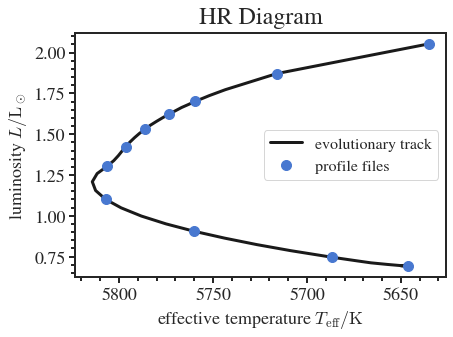

In [7]:
def plot_HR(profile_number=-1):
    plt.plot(10**DF['log_Teff'][1:], 
             10**DF['log_L'][1:], 
             lw=3, c='k', label='evolutionary track')
    
    first = 1
    for prof_num in index.profile_number:
        hist = get_history(prof_num)
        plt.plot(10**hist['log_Teff'], 10**hist['log_L'], '.',
                 c='r' if prof_num == profile_number else 'b', 
                 label=r'%0.2f Gyr' % (hist.star_age.values[0]/1e9)
                       if prof_num == profile_number else 'profile files' if first else '',
                 ms=20)
        if not prof_num == profile_number:
            first = 0
    
    plt.gca().invert_xaxis()
    plt.xlabel(r'effective temperature $T_{\rm{eff}}/\rm{K}$')
    plt.ylabel(r'luminosity $L/\rm{L}_\odot$')
    
    plt.legend()
    plt.title('HR Diagram', size=24)

plot_HR()

## Plot stellar structure 

In [8]:
def load_profile(profile_number, logs_dir=logs_dir):
    prof = pd.read_table(
        os.path.join(logs_dir, 'profile' + str(profile_number) + '.data'), 
        skiprows=5, sep='\s+')
    return prof

load_profile(5)

,zone,mass,logR,logT,logRho,logP,x_mass_fraction_H,y_mass_fraction_He,z_mass_fraction_metals,brunt_N2,brunt_N,lamb_S
0,1,1.000000e+00,0.052476,3.764049,-6.889572,4.702742,0.758465,0.225554,0.015981,3.129972e-04,0.017692,0.000014
1,2,1.000000e+00,0.052475,3.764571,-6.885950,4.706888,0.758465,0.225554,0.015981,3.120090e-04,0.017664,0.000014
2,3,1.000000e+00,0.052474,3.765330,-6.880855,4.712743,0.758465,0.225554,0.015981,3.070177e-04,0.017522,0.000014
3,4,1.000000e+00,0.052472,3.766483,-6.873374,4.721379,0.758465,0.225554,0.015981,3.019221e-04,0.017376,0.000014
4,5,1.000000e+00,0.052470,3.768020,-6.864006,4.732287,0.758465,0.225554,0.015981,2.914163e-04,0.017071,0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...
789,790,1.250073e-06,-2.746326,7.270412,2.484993,17.585421,0.045448,0.935152,0.019400,6.851040e-08,0.000262,0.519224
790,791,6.250366e-07,-2.846693,7.270431,2.485092,17.585493,0.045380,0.935221,0.019400,4.314907e-08,0.000208,0.654194
791,792,3.125184e-07,-2.947052,7.270443,2.485153,17.585539,0.045337,0.935264,0.019399,2.780587e-08,0.000167,0.824243
792,793,1.562592e-07,-3.047405,7.270451,2.485192,17.585567,0.045310,0.935291,0.019399,1.880355e-08,0.000137,1.038490


In [9]:
def get_profiles(index=index, logs_dir=logs_dir):
    return [load_profile(profile_number, logs_dir) 
            for profile_number in index.profile_number]

profs = get_profiles()

### Composition profile

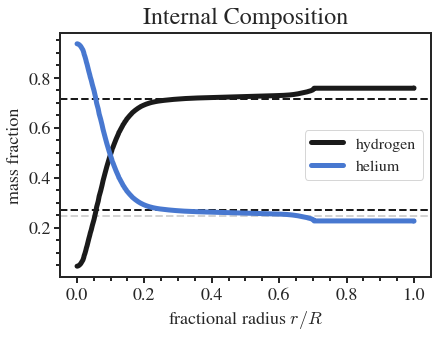

In [10]:
ZAMS_X = profs[0].x_mass_fraction_H.values[0]
ZAMS_Y = profs[0].y_mass_fraction_He.values[0]
Y_p = 0.2463

def plot_composition(profile_number):
    prof = profs[profile_number-1]
    x = 10**prof.logR / np.max(10**prof.logR)
    plt.plot(x, prof.x_mass_fraction_H, lw=5, label='hydrogen', c='k')
    plt.plot(x, prof.y_mass_fraction_He, lw=5, label='helium', c='b')
    plt.axhline(ZAMS_X, c='k', ls='--', zorder=-99)
    plt.axhline(ZAMS_Y, c='k', ls='--', zorder=-99)
    plt.axhline(Y_p, c='lightgray', ls='--', zorder=-99)
    plt.xlabel(r'fractional radius $r/R$')
    plt.ylabel(r'mass fraction')
    plt.legend()
    plt.title('Internal Composition', size=24)

plot_composition(5)

### Propagation diagram

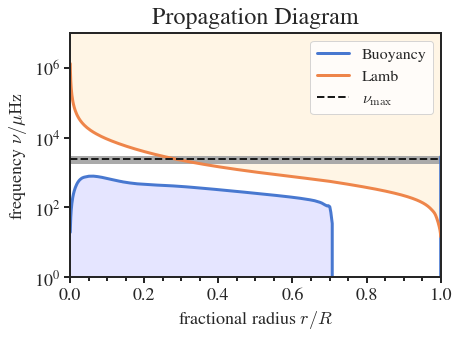

In [11]:
def plot_propagation(profile_number):
    hist = get_history(profile_number)
    prof = profs[profile_number-1]
    
    x = 10**prof.logR / np.max(10**prof.logR)
    brunt = prof.brunt_N.values/(2*np.pi)*1e6
    lamb  = prof.lamb_S.values*1e6
    plt.plot(x, brunt, lw=3, label='Buoyancy')
    plt.plot(x, lamb, lw=3, label='Lamb')
    
    gmodes = np.minimum(brunt, lamb)
    pmodes = np.maximum(brunt, lamb)
    plt.fill_between(x, 
                     np.zeros(len(gmodes)), 
                     gmodes, 
                     color='blue', alpha=0.1, zorder=-99)
    plt.fill_between(x, 
                     1e99*np.ones(len(pmodes)), 
                     pmodes, 
                     color='orange', alpha=0.1, zorder=-99)
    
    nu_max   = hist.nu_max.values[0]
    Delta_nu = hist.delta_nu.values[0]
    plt.axhline(nu_max, ls='--', c='k', label=r'$\nu_\max$', zorder=100)
    plt.fill_between([0, 1], 
                     nu_max-5*Delta_nu, 
                     nu_max+5*Delta_nu, 
                     color='#aaaaaa', zorder=-98)
    
    plt.semilogy()
    plt.ylim([1, 1e7]) #500*nu_max])
    plt.xlim([0,1])
    plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.xlabel(r'fractional radius $r/R$')
    plt.legend()
    plt.title('Propagation Diagram', size=24)

plot_propagation(5)

## Compute frequencies with GYRE

Now let's calculate some frequencies. An example GYRE inlist awaits you in the `src/` directory. Copy that over to your `LOGS/` directory and run it with GYRE: 

```
    cp ../src/gyre.in LOGS
    cd LOGS
    $GYRE_DIR/bin/gyre gyre.in
```

In [12]:
def get_frequencies(profile_number, logs_dir=logs_dir):
    path = os.path.join(logs_dir, 'profile' + str(profile_number) + '-freqs.dat')
    return pd.read_table(path, skiprows=5, sep='\s+')

get_frequencies(1)

,l,n_pg,n_p,n_g,Re(freq),Im(freq),E_norm
0,0,5,5,0,1008.891465,0.0,5.221518e-05
1,0,6,6,0,1193.463457,0.0,2.050384e-05
2,0,7,7,0,1374.107108,0.0,8.879054e-06
3,0,8,8,0,1554.899236,0.0,3.970259e-06
4,0,9,9,0,1733.817022,0.0,1.848356e-06
...,...,...,...,...,...,...,...
127,3,32,32,0,5833.606530,0.0,4.973277e-09
128,3,33,33,0,6003.226830,0.0,5.100117e-09
129,3,34,34,0,6172.589653,0.0,5.296962e-09
130,3,35,35,0,6341.487888,0.0,5.579146e-09


I've prepared a script in the `src/` directory that will allow us to efficiently obtain the frequencies of all our stellar models. Let's run that in a loop: 

```
    for FGONG in *.FGONG; do
        ../../src/gyre6freqs.sh -i $FGONG -f
    done
```

In [13]:
def get_all_frequencies(index=index, logs_dir=logs_dir):
    return [get_frequencies(profile_number, logs_dir=logs_dir) 
            for profile_number in index.profile_number]

freqs = get_all_frequencies()

### Echelle diagram

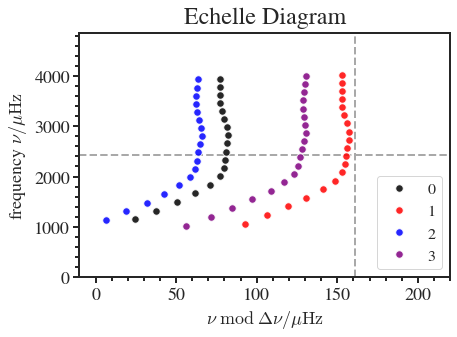

In [14]:
def plot_echelle(profile_number):
    hist = get_history(profile_number)
    prof = profs[profile_number-1]
    freq = freqs[profile_number-1]
    
    nu_max   = hist.nu_max.values[0]
    Delta_nu = hist.delta_nu.values[0]
    
    freq = freqs[1]
    freq = freq[freq['Re(freq)'] < 5/3*nu_max]
    radial = freq[np.logical_and(freq.l == 0, freq.n_p > 10)]
    Dnu = np.mean(np.diff(radial['Re(freq)'].values))
    
    colors = ('black', 'red', 'blue', 'purple')
    for ell in np.unique(freq.l.values):
        nus = freq[freq.l == ell]
        plt.plot(nus['Re(freq)'] % Dnu,
                 nus['Re(freq)'], '.', 
                 mfc=colors[ell], mec='white', alpha=0.85,
                 ms=15, mew=1, 
                 label=str(ell))
    
    plt.legend(loc='lower right')
    
    plt.axvline(Dnu, ls='--', c='darkgray', zorder=-99)
    plt.axhline(nu_max, ls='--', c='darkgray', zorder=-99)
    
    plt.ylim([0, nu_max*5/3*1.2])
    plt.xlim([-10, 220])
    
    plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.xlabel(r'$\nu\; \rm{mod}\; \Delta\nu/\mu\rm{Hz}$')
    plt.title('Echelle Diagram', size=24)

plot_echelle(5)

## Evolution! 

In [15]:
def plot_panels(profile_number):
    fig = plt.figure(figsize=(12,8))
    
    plt.subplot(2,2,1)
    plot_HR(profile_number)
    
    plt.subplot(2,2,2)
    plot_composition(profile_number)
    
    plt.subplot(2,2,4)
    plot_propagation(profile_number)
    
    plt.subplot(2,2,3)
    plot_echelle(profile_number)
    
    plt.tight_layout()

interact(plot_panels, profile_number=IntSlider(min=1, max=np.max(index.profile_number)));

interactive(children=(IntSlider(value=1, description='profile_number', max=11, min=1), Output()), _dom_classes…

## Eigenfunctions

Now let's go back into our `gyre.in` file and modify the `ad_output` block to the following in order to get eigenfunctions:

```
&ad_output
    summary_file = 'profile1-freqs.dat'
    summary_file_format = 'TXT'
    summary_item_list = 'l,n_pg,n_p,n_g,freq,E_norm' 
    freq_units = 'UHZ' 
    detail_file_format = 'TXT'
    detail_template = 'profile1-freqs/%L_%N'
    detail_item_list = 'M_star,R_star,l,n_pg,n_p,n_g,freq,E,E_p,E_g,E_norm,M_r,x,xi_r,xi_h'
/
```

Let's make a directory `profile1-freqs` to put the results in, and run GYRE:

```
    mkdir profile1-freqs
    $GYRE_DIR/bin/gyre gyre.in
```

Alternatively to all of the above, just call the `../../src/gyre6freqs.sh` script with the `-e` flag (for eigenfunctions):

    ../../src/gyre6freqs.sh -i profile1.data.FGONG -f -e

In [16]:
def get_eigenfunctions(profile_number):
    eig_dir = os.path.join(logs_dir, 'profile' + str(profile_number) + '-freqs')
    eigs = {}
    for fname in os.listdir(eig_dir):
        if fname[:2] != '00':
            continue
        eig_i = pd.read_table(os.path.join(eig_dir, fname), sep='\s+', skiprows=5)
        sph_deg, rad_ord = fname.split('_')
        eigs[(int(sph_deg), 'x')] = eig_i['x']
        eigs[(int(sph_deg), int(rad_ord))] = eig_i[['Re(xi_r)', 'Re(xi_h)']]
    return eigs

eigs = get_eigenfunctions(1)
eigs[(1,10)]

,Re(xi_r),Re(xi_h)
0,0.474572,0.474572
1,0.474518,0.474560
2,0.474489,0.474548
3,0.474440,0.474531
4,0.474361,0.474504
...,...,...
1077,1493.239058,5.498219
1078,1494.030036,5.501026
1079,1494.821727,5.503834
1080,1495.614133,5.506644


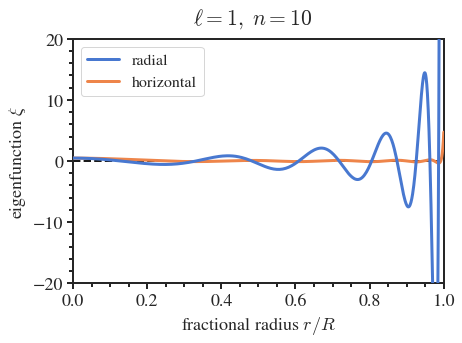

In [17]:
def plot_eigs(sph_deg, rad_ord):
    x   = eigs[(sph_deg, 'x')]
    eig = eigs[(sph_deg, rad_ord)]
    plt.plot(x, eig['Re(xi_r)'], label='radial',     lw=3, zorder=11)
    plt.plot(x, eig['Re(xi_h)'], label='horizontal', lw=3, zorder=10)
    
    plt.xlabel(r'fractional radius $r/R$')
    plt.ylabel(r'eigenfunction $\xi$')
    plt.axhline(0, ls='--', c='k', alpha=1, zorder=-10)
    
    plt.xlim([0,1])
    plt.ylim([-20, 20])
    
    plt.suptitle(r'$\ell = {%d},\; n = {%d}$' % (sph_deg, rad_ord))
    plt.legend(loc='upper left')

plot_eigs(1, 10)

In [18]:
interact(plot_eigs, 
         sph_deg=IntSlider(min=0, max=3,  step=1, value=1), 
         rad_ord=IntSlider(min=5, max=36, step=1, value=15));

interactive(children=(IntSlider(value=1, description='sph_deg', max=3), IntSlider(value=15, description='rad_o…

## A small grid 

Let's now try to run a grid of tracks with different masses. We'll begin by copying our work over to a new directory and removing the logs files: 

```
cp -R work grid
cd grid
rm -rf LOGS
```

Now let's edit `inlist_project` to stop the run at a central hydrogen fraction of 0.1, and also specify the `log_directory = '1'` in the `&controls` block. 

We want to run a grid of models, which means we need a way to automatically change parameters of the inlist in a loop. Here is a bash function that will do just that: 

```
INLIST=inlist_project 
change() { 
    # Modifies a parameter in the current inlist. 
    # args: ($1) name of parameter 
    #       ($2) new value 
    #       ($3) filename of inlist where change should occur 
    # example command: change initial_mass 1.3 
    # example command: change log_directory 'LOGS_MS' 
    # example command: change do_element_diffusion .true. 
    param=$1 
    newval=$2 
    filename=$3 
    escapedParam=$(sed 's#[^^]#[&]#g; s#\^#\\^#g' <<< "$param")
    search="^\s*\!*\s*$escapedParam\s*=.+$" 
    replace="    $param = $newval" 
    if [ ! "$filename" == "" ]; then
        sed -r -i.bak -e "s#$search#$replace#g" $filename 
    fi
    if [ ! "$filename" == "$INLIST" ]; then 
        change $param $newval "$INLIST"
    fi 
} 
```

Now we are ready to calculate a small grid: 

```
for M in 0.7 0.8 0.9 1.0 1.1 1.2; do
    echo "Running mass $M"
    change initial_mass $M
    change log_directory "'$M'"
    ./rn

    cd $M
    for FGONG in *.FGONG; do
        ../../src/gyre6freqs.sh -i $FGONG -f -t $OMP_NUM_THREADS
    done
    cd -
done 
```

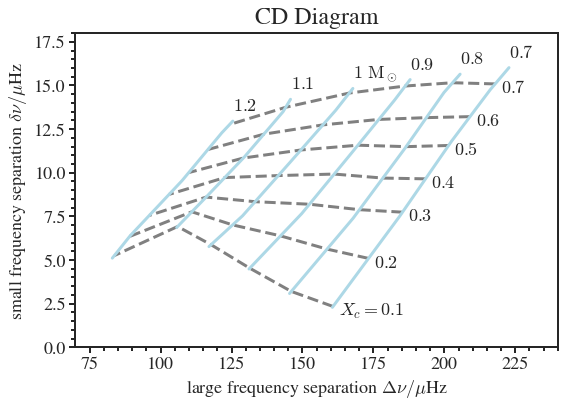

In [24]:
plt.figure(figsize=(8,6))
X_cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
Dnus_, dnus_ = [], []
for mass in ("0.7", "0.8", "0.9", "1.0", "1.1", "1.2"):
    logs_dir_ = os.path.join("grid", mass)
    DF_    = load_history_file          (logs_dir_)
    index_ = get_index                  (logs_dir_)
    profs_ = get_profiles       (index_, logs_dir_)
    freqs_ = get_all_frequencies(index_, logs_dir_)
    
    Dnus, dnus, X_c = [], [], []
    for prof_num, freq_ in enumerate(freqs_):
        hist = get_history(prof_num+1, DF=DF_, index=index_)
        nu_max = hist.nu_max.values[0]
        freq_ = freq_[freq_['Re(freq)'] < 5/3*nu_max]
        
        l0 = freq_[np.logical_and(freq_.l == 0, freq_.n_p > 10)].copy()
        l2 = freq_[np.logical_and(freq_.l == 2, freq_.n_p > 10)].copy()
        l2.n_p += 1 
        freq_merge = pd.merge(l0, l2, on='n_p')
        freq_merge['d02'] = freq_merge['Re(freq)_x'] - freq_merge['Re(freq)_y']
        
        Dnus += [np.mean(np.diff(l0['Re(freq)'].values))]
        dnus += [np.mean(freq_merge['d02'])]
        X_c  += [hist.center_h1.values[0]]
    
    plt.plot(Dnus, dnus, c='lightblue', lw=3, zorder=10)
    plt.text(Dnus[0], dnus[0]+0.6, r'$'+mass+r'$' 
             if mass!='1.0' else r'$1~\rm{M_\odot}$')
    
    Dnus_ += [sp.interpolate.interp1d(X_c, Dnus)(X_cs)]
    dnus_ += [sp.interpolate.interp1d(X_c, dnus)(X_cs)]

for idx, X_c in enumerate(X_cs):
    Dnus = np.array([Dnu[idx] for Dnu in Dnus_])
    dnus = np.array([dnu[idx] for dnu in dnus_])
    plt.plot(Dnus, dnus, c='gray', ls='--', lw=3)
    plt.text(Dnus[0]+2, dnus[0]-0.5, r'$'+str(X_c)+r'$' if X_c!=0.1 else r'$X_c = 0.1$')

plt.ylim([0, 18])
plt.xlim([70, 240])
plt.xlabel(r'large frequency separation $\Delta\nu/\mu$Hz')
plt.ylabel(r'small frequency separation $\delta\nu/\mu$Hz')
plt.title('CD Diagram', size=24)
plt.tight_layout()

Additional useful resources
---

- [tomso](https://tomso.readthedocs.io/): Tools for Models of Stars and their Oscillations
- [astero](https://cococubed.com/mesa_market/astero_module.html): Overview of the `astero` module 
- [tulips](https://astro-tulips.readthedocs.io/): Tools for Understanding the Lives, Interiors, and Physics of Stars